# AdaBoost

In AdaBoost, each preceeding learner looks into training instances the previous learner underfitted. As a result, as learner gradually improves by looking into harder and harder training cases. The actual progression and improvement of each sequential model is done by increasing the weights of misclassified instances from the previous model. In this way, the error in relation to the misclassified instances are weighted more and will _more_ likely not be misclassified incorrectly again in the next run. This is where the term "boosting" comes from. The algorithm "boosts" the misclassified weights.

This sequential training type of algorithm has properties to gradient descent, where the in the process, the weights get tuned to reflect the minimization of loss over time.

Finally, all the predictors in the boosting enemble will form a weighted prediction based off its performance on the training set. Note that even though each preceeding enemble is expected to out perform the previous one, there is no guarentee that it will, since the updated weights may result in misclassing previously correctly classificated results.


### Example

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split


X, y = make_moons(n_samples=700, noise=.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from myutils.draw.classification import plot_decision_boundary


ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, 
                             algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
plot_decision_boundary(ada_clf, X, y)

To demonstrate the sort of sequential process that happens, SVC (support vector classifier) supports `sample_weights` in which it becomes possible to specify higher weights to the samples to emphasize them more.

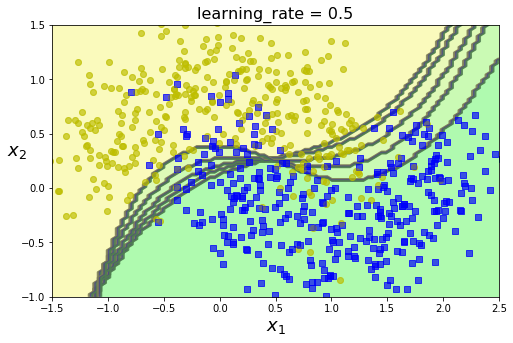

In [3]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

m = len(X_train)
plt.figure(figsize=(8, 5))
learning_rate = 0.5
sample_weights = np.ones(m)

for i in range(5):
    svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
    svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = svm_clf.predict(X_train)
    
    # increase the weights on the samples that were misclassified
    sample_weights[y_pred != y_train] *= (1 + learning_rate)
    plot_decision_boundary(svm_clf, X, y, alpha=.2)
    plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

### The Adaboost Algorithm

1. Initial a set of uniform weights that will sum to 1. (A weight vector of size m)

| sample | weight |
|--------|--------|
| 1      | 1/m    |
| 2      | 1/m    |
| 3      | 1/m    |
| .      | .      |
| .      | .      |
| .      | .      |
| m      | 1/m    |

**Why**: each sample gets emphasized at the start to the same degree. And normalization keeps things clean.



2. Train the first predictor, and compute the overall error of the jth predictor.

$$r_{ij} = \frac{\sum_{i=1 \\ \hat{y}_j^{(i)} \neq y^{(i)}}^m w^{(i)}}{\sum_{i=1}^m w^{(i)}}$$

* $r_j$ = the weighted error of the jth predictor. (j=1) in the first case.
* The numerator is the sum of the weights associated with the samples that where misclassified.
* The denominator is just the sum of all the weights. Which will always be 1 if the weights are already normalized.

**Why**: The result gives us a measure of how well the classifier performed on the basis of how much much the misclassification matters. The more misclassifications, then the higher $r_j$ will become, and vise-versa.


3. Determine the overall weight of the predictor. This will be used in the context of updating the rules as well as forming a final prediction.

$$\alpha_j = \eta log(\frac{1-r_j}{r_j})$$


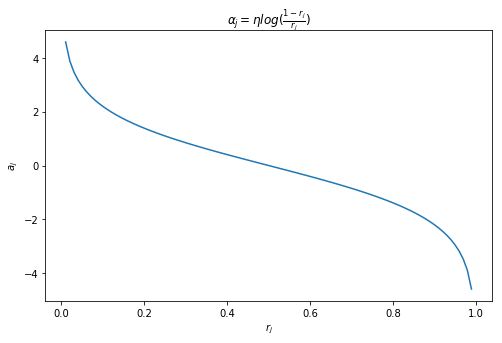

In [4]:
import numpy as np
from myutils.draw.math import plt_2d_functions


plt_2d_functions([lambda r: np.log((1-r)/r)], np.arange(.01, 1, .01), fig_size=(8, 5), 
                 title=r"$\alpha_j = \eta log(\frac{1-r_j}{r_j})$", xlabel=r"$r_j$", ylabel=r"$a_j$")

* $\eta$ is just scales the value of the weight. We will see how in the context of updating the weights - the effect this will bring.
* log gives it that smooth vertically mirrored shape so it will have the properties discussed below.

**Why**: The value of $a_j$ only directly relates in the context of forming a final weighted prediction. If the particular predictor $a_j$ is often correct, then $r_j$ will be small and the predictor will carry and exponentially higher weight. In the case when the predictor is equally wrong and correct, the weight will be 0 and the predictor will essentially be ignored in the final prediction. And finally, if the predictor is often wrong, $r_j$ will be high and the weight will be negative, and as a result will work against its vote in the final classification. Why have an exponential property? What this is saying is that if you perform well, the more you will be rewarded, and the worst you perform the more you will be punished. Why does such a philosophy work? I think this is because we value predictors that significantly more if they perform excellent than predictors that perform just ok. There is a degree of unfairness involved, and it makes sense because we want to keep the best of the pack as the supreme leaders.


4. Update the weight of each sample according to the weight of the predictor.

$$
    w^{(i)} =
    \begin{cases} 
    w^{(i)} & \hat{y}^{(i)} = y^{(i)} \\
          w^{(i)}e^{\alpha_j} & \hat{y}^{(i)} \neq y^{(i)} \\
    \end{cases}
$$


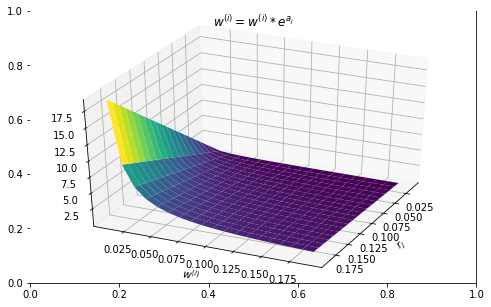

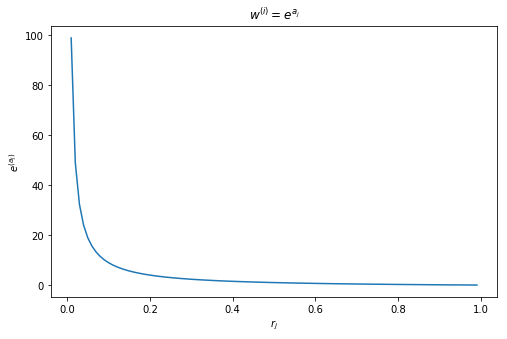

In [5]:
from myutils.draw.math import plt_3d_functions
from math import e


plt_3d_functions([lambda w, r: w * (e ** np.log((1-r)/r))], np.arange(.01, .20, .01), np.arange(.01, 0.20, .01), fig_size=(8, 5), 
                  title=r"$w^{(i)} = w^{(i)}*e^{a_j}$", xlabel=r"$r_j$", ylabel=r"$w^{(i)}$",
                  elev=35, azim=25)

plt_2d_functions([lambda r: e**(np.log((1-r)/r))], np.arange(.01, 1, .01), fig_size=(8, 5), 
                  title=r"$w^{(i)} = e^{a_j}$", xlabel=r"$r_j$", ylabel=r"$e^{(a_j)}$")


* If for predictor j, $r_j$ is high (higher error), then $a_j$ follows to be negative, and the final updated weight will be smaller for the misclassified weights. And if the weight was low previously, the effect will get compounded, and the weight becomes even smaller.
* The weights for correctly classified weights will remain the same.

5. Normalize the weights by dividing each weight by $sum_{i=1}^m w^{(i)}$. This way, everythings sums back to 1.

6. If the stop conditions are not met, retrain the next predictor using these updated weights. (see step 1). The stopping conditions could be 1) a perfect predictor is reached, 2) the maximum number of predictors are met.

7. Form a final prediction. Use each predictor to make a classification for input sample x. Assign a score to the predicted classification as $\alpha_j$. Then obtain the final classification by taking the majority weighted vote.

$$\hat{y}(x) = \text{argmax}_k \sum_{j=1 \\ \hat{y_j}(x)}^N \alpha_j$$